# Code to invert PV distribution and find geopotential using SOR

# Case 2: Set a 50x50x19 domain

In [1]:
import numpy as np
from numpy import *
#import scipy.linalg
import matplotlib.pyplot as plt

A = 2.                      # Vorticity Coefficient
Lx = 50.0                    # x-length scale, domain size ""
Ly = 50.0                    # y-length scale, domain size
Lz = 50.0                   # z-length scale, domain size
nx = 51                     # number of grid points in x
ny = 51                     # number of grid points in y
nz = 20                     # number of grid points in z
nxm2 = nx - 2               # number of grid points in x, minus boundary points
nym2 = ny - 2               # number of grid points in y, minus boundary points
nzm2 = nz - 2               # number of grid points in z, minus boundary points
index_in = nxm2*nym2*nzm2        # number of points in interior of gridspace
x1d = linspace(0,Lx,nx)     # linspace = return evenly spaced numbers over an interval.Evenly space number of grid points in y-direction of domain length
y1d = linspace(0,Ly,ny)     # Evenly space number of grid points in y-direction of domain length
z1d = linspace(0,Lz,nz)     # Evenly space number of grid points in z-direction of domain length
dx=x1d[1]-x1d[0]            # Distance between x-grid points
dy=y1d[1]-y1d[0]            # Distance between y-grid points
dz=z1d[1]-z1d[0]            # Distance between z-grid points
vorgrid=np.zeros((nx,ny,nz))   # initialize vorticity grid points to zero
temp=np.zeros((nx,ny,nz))  
x,y,z=np.meshgrid(x1d,y1d,z1d,indexing='ij') 

# define stuff for operators, expierement with this
omega = 1.94               # relaxation parameter 
psib = 0.                   # value to set streamfunction to
psi=np.ones((nx,ny,nz))*psib      # set all streamfunction grid points to value "psib"
sigma=dx/dy
threshold = .01
print(dx)

# Create Gaussian grid

xc = 25    # i coordinate of vortex in gridpoint space
yc = 25    # j coordinate of vortex in gridpoint space
zc = 9  # k coordinate of vortex in gridpoint space

#PV perturbation
for i in range(nx):
    for j in range(ny):
        for k in range(nz):
            vorgrid[i,j,k] = 100 * np.exp(-((i - xc) ** 2. + (j - yc) ** 2. + (k - zc) ** 2.) /100.)
            
lev = 9
fig = plt.figure(figsize=(6,6))             # plot a figure that is size 6x6
cs = plt.contourf(x[:,:,lev],y[:,:,lev],vorgrid[:,:,lev],cmap='summer')    # plot stream function fill pattern
cs = plt.contour(x[:,:,lev],y[:,:,lev],vorgrid[:,:,lev],colors='black')    # plot stream function contours 
plt.clabel(cs, fmt='%.1f', inline=True)     # plot contour labels
plt.title('vorticity')        # plot title    
plt.show()

1.0


<Figure size 600x600 with 1 Axes>

In [2]:
#Define constants
R = 287.05 #J kg^-1 K^-1
kappa=0.2856219 #Rd / cp
cp = 1004.7 #J kg^-1 K^-1
pref = 1000. #hPa
g = 9.80665 #gravity
omega = 7.292e-5 #Earth's rotation rate (s^-1)
a = 2.e7 / np.pi #Radius of the earth (m)
p0=1.e5
alpha=-1./5.255877
gamma = 0.0065 #lapse rate, (K/m)
delp = 5000. #hPa
dellatstar = (np.pi/180.) * a
dellonstar = (np.pi/180.) * a
sigma1 = dellonstar / dellatstar
sigma2 = dellonstar / delp

In [3]:
#Define pressure level array
pb = 1000. #base pressure
pb_half = 975.
pt = 100. #top pressure
pt_half = 125.
p = np.linspace(pb,pt,19) #make array of size 19 with even spacing from base pressure to top pressure
#p_half = np.linspace(pb_half,pt_half,18)
delp = (p[0] - p[1]) * 100. #Convert to hPa

In [4]:
#Manually define phalf based on length of k and pressure values
phalf = np.zeros((len(p)-1))
for i in range(len(p)-1):
    phalf[i] = (p[i+1] + p[i]) / 2.

In [5]:
#Define latitude and longitude arrays
lat = np.arange(1,ny,1)
lon = np.arange(1,nx,1)
lenlat = len(lat)

In [6]:
#Standard atmosphere geopotential, potential temperature, and stability function
def standard_atmosphere(p, p_half):
    g=9.8066
    kappa=0.2856219
    alpha=-1./5.255877
    beta=-6341.624
    gamma=.0065
    R=287.04
    cp = 1004.7
    p00=1000.
    nlevels = p.size
    nlevels_half = p_half.size

    Z = np.zeros(nlevels)
    phi = np.zeros(nlevels)
    T = np.zeros(nlevels)
    theta = np.zeros(nlevels)

    T_half = np.zeros(nlevels)
    theta_half = np.zeros(nlevels_half)
    dthetadp = np.zeros(nlevels_half)
    S = np.zeros(nlevels_half)

    for k in np.arange(nlevels):
        if (p[k] > 226.32):
            Z[k] = (288.15/gamma) * ( 1. - (1013.25/p[k])**alpha)
            T[k] = 288.15 - 0.0065*Z[k]
            theta[k] = T[k] * (1000./p[k])**(R/cp)
        else:
            T[k] = 216.65
            Z[k] = (11.e3+beta*np.log(p[k]/226.32))
            theta[k] = T[k] * (1000./p[k])**(R/cp)
                
    for k in np.arange(nlevels_half):
        if (p_half[k] > 226.32):
            T_half[k] = 288.15 - 0.0065*Z[k]
            theta_half[k] = T_half[k] * (1000./p_half[k])**(R/cp)
        else:
            T_half[k] = 216.65
            theta_half[k] = T_half[k] * (1000./p_half[k])**(R/cp)
    
    for k in np.arange(nlevels_half):
        dthetadp[k] = (theta[k+1] - theta[k-1])/(1.e2*(p[k+1]-p[k-1]))
        S[k] =  -R*(T_half[k]/theta_half[k])*dthetadp[k]/(p[k]*100.)
    return g*Z, T, S

In [7]:
#Calculate standard atmosphere geopotential (geop), potential temp (tmpk), and stability
SAgeop, SAtmpk, stability = standard_atmosphere(p, phalf)

In [8]:
#Calculate Coriolis parameter
lenlat = len(lat)
cor = np.zeros((lenlat))
for j in range(lenlat):
    cor[j] = 2. * omega * np.sin(lat[j]*(np.pi / 180.)) # degrees to radians

In [9]:
#Calculate Rossby parameter (beta), variation in Coriolis force with respect to changing latitude
beta = np.zeros((lenlat))
for j in range(lenlat):
    beta[j] = (2. * omega / a) * np.cos(lat[j] * (np.pi / 180.))

In [10]:
#Calculate mean Coriolis Parameter weighted by latitude
fo = 0.
dlat = lat[49] - lat[0]
for j in range(lenlat):
    fo = fo + (cor[j] / (dlat+1)) #fo = fo + (cor[j] / (jlen-1))

In [11]:
d2r=np.pi/180.
a = 6371.e3
dlon = a*0.5*d2r
dlat = a*0.5*d2r
dp = 50.e2
gamma=.0065
omega = 7.292E-5
f0 = 0.5*(2*omega*(np.sin(d2r*lat[0])+np.sin(d2r*lat[-1])))

In [12]:
#Calculate relative vorticity coefficients
lat_rad = lat * d2r
A1 = np.zeros((lenlat))
A2 = np.zeros((lenlat))
A3 = np.zeros((lenlat))
A4 = np.zeros((lenlat))
A5 = np.zeros((lenlat))

for j in range(1, len(lat)-1):
    coslat_mh = (np.cos(lat_rad[j]) + np.cos(lat_rad[j-1]))/2.
    coslat_ph = (np.cos(lat_rad[j]) + np.cos(lat_rad[j+1]))/2.
    coslat = np.cos(lat_rad[j])
    
    A1[j] = coslat_mh / coslat * sigma2
    A2[j] = 1 / (coslat ** 2.)
    A3[j] = -((2 / (coslat ** 2.)) + sigma2 / coslat * (coslat_mh + coslat_ph))
    A4[j] = A2[j]
    A5[j] = sigma2 * coslat_ph / coslat
            

In [13]:
#Calculate stretching vorticity coefficients
stability_r = 1. / stability
Sph_r = np.append(stability_r, stability_r[-1])
Smh_r = np.append(stability_r[0], stability_r)
A3_str = -(Smh_r + Sph_r) * fo ** 2. / dp ** 2.
A6 = Smh_r * fo ** 2. / dp ** 2.
A7 = Sph_r * fo ** 2. / dp ** 2.

A3i_qgpv = np.zeros((ny,nz))
A3i_qgpv = A3_str[None,:] + A3[:,None]

In [14]:
#Define top and bottom temperatures based on standard atmosphere
tmpk_top = SAtmpk[-1]
tmpk_bottom = SAtmpk[0]

In [15]:
# do the iterations below (use max_iters in case the solution doesn't converge) 
errvar = 1.e-6        # value of error threshold
psib = 10.
psi=ones((nx,ny,nz))*psib
max_iters=156         # maximum number of iterations
dlambda = (a * dlat * d2r)
res_list = []
for iteration in range(max_iters):
    error = 0
    #boundaries
    psi[:,:,0] = psi[:,:,1] - (R/p[0])*tmpk_top
    psi[:,:,-1] = psi[:,:,-2] + (R/p[-1])*tmpk_bottom
    #print("Iteration= ",iteration)
    for i in np.arange(1,nx-2):
        for j in np.arange(1,ny-2):
            for k in np.arange(1,nz-1):
                # interior points
                lap = (A1[j] * psi[i,j-1,k]) + (A2[j] * psi[i-1,j,k]) + (A3[j] * psi[i,j,k]) + (A4[j] * psi[i+1,j,k]) + (A5[j] * psi[i,j+1,k])     # calculation of residual
                stretch = ((A6[k] * psi[i,j,k-1]) + (A3_str[k] * psi[i,j,k]) + (A7[k] * psi[i,j,k+1]))
                res = lap + stretch - (vorgrid[i,j,k] * (dlambda ** 2.))
                psi[i,j,k] = psi[i,j,k] - ((1.9 * res) / A3i_qgpv[i,k])    # calculation of stream function
            
                error = error + abs(res)
                #print(stretch)
  
                # Uncomment the 2 lines below to set up a Neumann condition along the eastern boundary
                #if i==nx-2:
                    #psi[i,j-1,k]=psi[i,j,k]
        unit_error = error/((nxm2)*(nym2)*(nzm2))
        res_list.append(unit_error)                    
        # if error threshold is met, break out of loop
    if(unit_error < errvar):      # error threshold, average absolute error must be less than specified
        print('amount of error:')
        print('got here: ',error/(nxm2*nym2*nzm2), iteration)
        break
        
        # number of iterations until convergence
print('hmm . . . number of iterations = ', iteration)  

hmm . . . number of iterations =  155


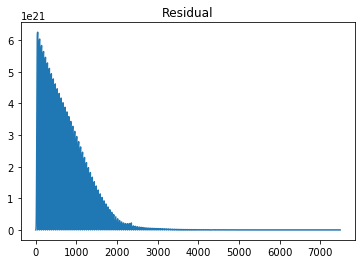

In [16]:
#Plot residual error
plt.plot(res_list)
plt.title("Residual")
plt.show()

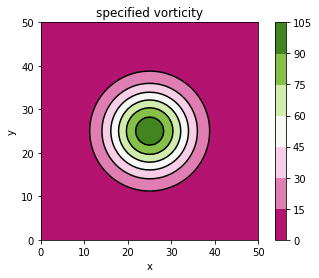

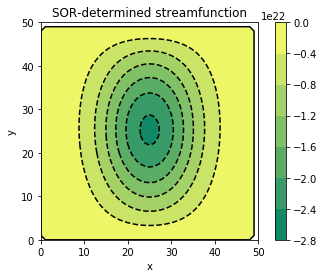

In [17]:
#Horizontal plot
lev = 9
# plot junk
fig = plt.figure()
cs1 = plt.contourf(x[:,:,lev],y[:,:,lev],vorgrid[:,:,lev],cmap='PiYG') 
cs = plt.contour(x[:,:,lev],y[:,:,lev],vorgrid[:,:,lev],colors='black')
fig.colorbar(cs1)
plt.title('specified vorticity')
plt.xlabel('x')
plt.ylabel('y')
ax=plt.gca()
ax.set_aspect('equal')
plt.show()       

fig = plt.figure()
cs1 = plt.contourf(x[:,:,lev],y[:,:,lev],psi[:,:,lev],cmap='summer')
cs = plt.contour(x[:,:,lev],y[:,:,lev],psi[:,:,lev],colors='black')
fig.colorbar(cs1)
plt.title('SOR-determined streamfunction')
plt.xlabel('x')
plt.ylabel('y')
ax=plt.gca()
ax.set_aspect('equal')
plt.show()

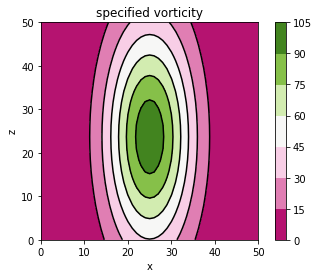

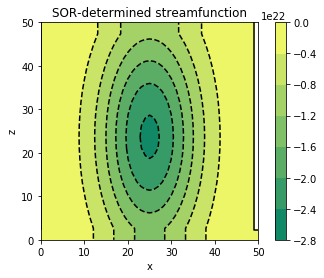

In [18]:
#Vertical cross section
lev = 25
# plot junk
fig = plt.figure()
cs1 = plt.contourf(x[:,lev,:],z[:,lev,:],vorgrid[:,lev,:],cmap='PiYG') 
cs = plt.contour(x[:,lev,:],z[:,lev,:],vorgrid[:,lev,:],colors='black')
fig.colorbar(cs1)
plt.title('specified vorticity')
plt.xlabel('x')
plt.ylabel('z')
ax=plt.gca()
ax.set_aspect('equal')
plt.show()       

fig = plt.figure()
cs1 = plt.contourf(x[:,lev,:],z[:,lev,:],psi[:,lev,:],cmap='summer')
cs = plt.contour(x[:,lev,:],z[:,lev,:],psi[:,lev,:],colors='black')
fig.colorbar(cs1)
plt.title('SOR-determined streamfunction')
plt.xlabel('x')
plt.ylabel('z')
ax=plt.gca()
ax.set_aspect('equal')
plt.show()

# Case 3: Warm anomaly at bottom

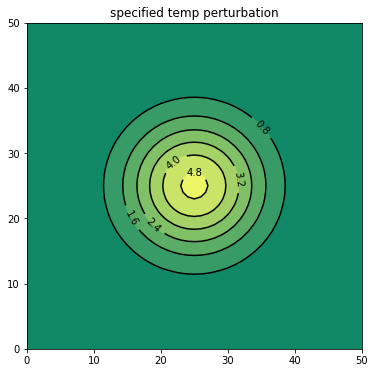

In [44]:
# Create Gaussian grid
tmpk_prime = np.zeros((nx,ny,nz))
xc = 25    # i coordinate of vortex in gridpoint space
yc = 25    # j coordinate of vortex in gridpoint space
zc = 0  # k coordinate of vortex in gridpoint space

#PV perturbation
for i in range(nx):
    for j in range(ny):
        for k in range(nz):
            tmpk_prime[i,j,k] = 5. * np.exp(-((i - xc) ** 2. + (j - yc) ** 2. + (k - zc) ** 2.) /100.)
            
lev = 0
fig = plt.figure(figsize=(6,6))             # plot a figure that is size 6x6
cs = plt.contourf(x[:,:,lev],y[:,:,lev],tmpk_prime[:,:,lev],cmap='summer')    # plot stream function fill pattern
cs = plt.contour(x[:,:,lev],y[:,:,lev],tmpk_prime[:,:,lev],colors='black')    # plot stream function contours 
plt.clabel(cs, fmt='%.1f', inline=True)     # plot contour labels
plt.title('specified temp perturbation')        # plot title    
plt.show()

In [45]:
#tmpk_top = (SAtmpk[-1] + SAtmpk[-2])/2.
#tmpk_btm = (SAtmpk[0] + SAtmpk[1])/2.

tmpk_top = (tmpk_prime[:,:,-1] + tmpk_prime[:,:,-2])/2. * 100000.
tmpk_btm = (tmpk_prime[:,:,0] + tmpk_prime[:,:,1])/2. * 100000.

# Set interior q' to 0
vorgrid = np.zeros((nx, ny, nz))

In [46]:
# do the iterations below (use max_iters in case the solution doesn't converge) 
errvar = 1.e-6        # value of error threshold
psib = 10.
psi=ones((nx,ny,nz))*psib
max_iters=156         # maximum number of iterations
dlambda = (a * dlat * d2r)
res_list = []
for iteration in range(max_iters):
    error = 0
    #boundaries
    psi[:,:,0] = psi[:,:,1] - (R/p[0])*tmpk_top*(dp/fo)
    psi[:,:,-1] = psi[:,:,-2] + (R/p[-1])*tmpk_btm*(dp/fo)
    #print("Iteration= ",iteration)
    for i in np.arange(1,nx-2):
        for j in np.arange(1,ny-2):
            for k in np.arange(1,nz-1):
                # interior points
                lap = (A1[j] * psi[i,j-1,k]) + (A2[j] * psi[i-1,j,k]) + (A3[j] * psi[i,j,k]) + (A4[j] * psi[i+1,j,k]) + (A5[j] * psi[i,j+1,k])     # calculation of residual
                stretch = ((A6[k] * psi[i,j,k-1]) + (A3_str[k] * psi[i,j,k]) + (A7[k] * psi[i,j,k+1]))
                res = lap + stretch - (vorgrid[i,j,k] * (dlambda ** 2.))
                psi[i,j,k] = psi[i,j,k] - ((1.9 * res) / A3i_qgpv[i,k])    # calculation of stream function
            
                error = error + abs(res)
                #print(stretch)
  
                # Uncomment the 2 lines below to set up a Neumann condition along the eastern boundary
                #if i==nx-2:
                    #psi[i,j-1,k]=psi[i,j,k]
        unit_error = error/((nxm2)*(nym2)*(nzm2))
        res_list.append(unit_error)                    
        # if error threshold is met, break out of loop
    if(unit_error < errvar):      # error threshold, average absolute error must be less than specified
        print('amount of error:')
        print('got here: ',error/(nxm2*nym2*nzm2), iteration)
        break
        
        # number of iterations until convergence
print('hmm . . . number of iterations = ', iteration)  

hmm . . . number of iterations =  155


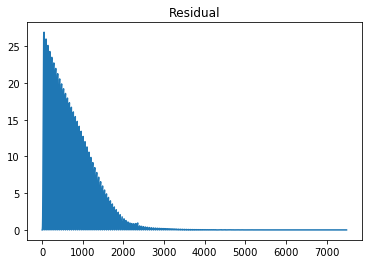

In [47]:
#Plot residual error
plt.plot(res_list)
plt.title("Residual")
plt.show()

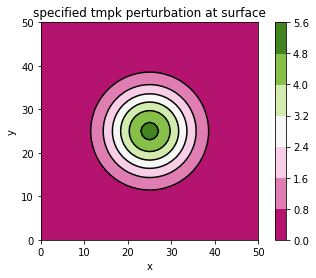

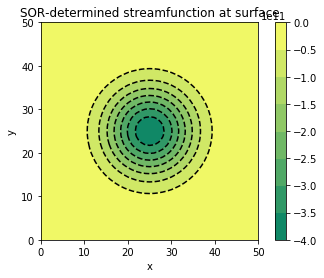

In [48]:
#Horizontal plot
lev = 0
# plot junk
fig,ax = plt.subplots()
cs1 = ax.contourf(x[:,:,lev],y[:,:,lev],tmpk_prime[:,:,lev],cmap='PiYG') 
cs = ax.contour(x[:,:,lev],y[:,:,lev],tmpk_prime[:,:,lev],colors='black')
fig.colorbar(cs1, orientation='vertical')
ax.set_title('specified tmpk perturbation at surface')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax=plt.gca()
ax.set_aspect('equal')
plt.show()       

fig,ax = plt.subplots()
cs1 = ax.contourf(x[:,:,lev],y[:,:,lev],psi[:,:,lev],cmap='summer')
cs = ax.contour(x[:,:,lev],y[:,:,lev],psi[:,:,lev],colors='black')
fig.colorbar(cs1)
ax.set_title('SOR-determined streamfunction at surface')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax=plt.gca()
ax.set_aspect('equal')
plt.show()

In [49]:
#Calculate mean psi at specified vertical level
lev = 0
psimean = np.mean(np.squeeze(psi[:,lev,:]))

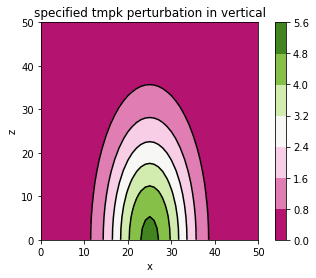

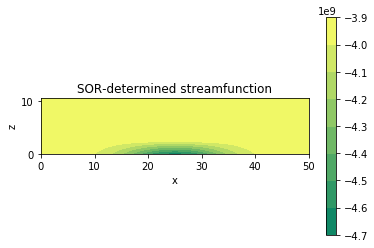

In [50]:
#Vertical cross section
lev = 25
# plot junk
fig = plt.figure()
cs1 = plt.contourf(x[:,lev,:],z[:,lev,:],tmpk_prime[:,lev,:],cmap='PiYG') 
cs = plt.contour(x[:,lev,:],z[:,lev,:],tmpk_prime[:,lev,:],colors='black')
fig.colorbar(cs1)
plt.title('specified tmpk perturbation in vertical')
plt.xlabel('x')
plt.ylabel('z')
ax=plt.gca()
ax.set_aspect('equal')
plt.show()       

lev = 0
fig = plt.figure()
cs1 = plt.contourf(x[:,lev,:5],z[:,lev,:5],psi[:,lev,:5]-psimean,cmap='summer')
#cs = plt.contour(x[:,lev,:5],z[:,lev,:5],psi[:,lev,:5]-psimean,colors='black')
fig.colorbar(cs1)
plt.title('SOR-determined streamfunction')
plt.xlabel('x')
plt.ylabel('z')
ax=plt.gca()
ax.set_aspect('equal')
plt.show()

# Case 4: Cold anomaly at top

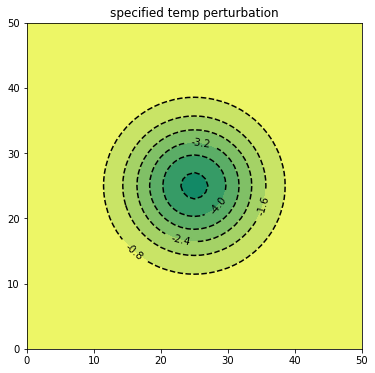

In [61]:
# Create Gaussian grid
tmpk_prime = np.zeros((nx,ny,nz))
xc = 25    # i coordinate of vortex in gridpoint space
yc = 25    # j coordinate of vortex in gridpoint space
zc = 19  # k coordinate of vortex in gridpoint space

#PV perturbation
for i in range(nx):
    for j in range(ny):
        for k in range(nz):
            tmpk_prime[i,j,k] = -5. * np.exp(-((i - xc) ** 2. + (j - yc) ** 2. + (k - zc) ** 2.) /100.)
            
lev = 19
fig = plt.figure(figsize=(6,6))             # plot a figure that is size 6x6
cs = plt.contourf(x[:,:,lev],y[:,:,lev],tmpk_prime[:,:,lev],cmap='summer')    # plot stream function fill pattern
cs = plt.contour(x[:,:,lev],y[:,:,lev],tmpk_prime[:,:,lev],colors='black')    # plot stream function contours 
plt.clabel(cs, fmt='%.1f', inline=True)     # plot contour labels
plt.title('specified temp perturbation')        # plot title    
plt.show()

In [62]:
#tmpk_top = (SAtmpk[-1] + SAtmpk[-2])/2.
#tmpk_btm = (SAtmpk[0] + SAtmpk[1])/2.

tmpk_top = (tmpk_prime[:,:,-1] + tmpk_prime[:,:,-2])/2. * 100000.
tmpk_btm = (tmpk_prime[:,:,0] + tmpk_prime[:,:,1])/2. * 100000.

# Set interior q' to 0
vorgrid = np.zeros((nx, ny, nz))

In [63]:
# do the iterations below (use max_iters in case the solution doesn't converge) 
errvar = 1.e-6        # value of error threshold
psib = 10.
psi=ones((nx,ny,nz))*psib
max_iters=156         # maximum number of iterations
dlambda = (a * dlat * d2r)
res_list = []
for iteration in range(max_iters):
    error = 0
    #boundaries
    psi[:,:,0] = psi[:,:,1] - (R/p[0])*tmpk_top*(dp/fo)
    psi[:,:,-1] = psi[:,:,-2] + (R/p[-1])*tmpk_btm*(dp/fo)
    #print("Iteration= ",iteration)
    for i in np.arange(1,nx-2):
        for j in np.arange(1,ny-2):
            for k in np.arange(1,nz-1):
                # interior points
                lap = (A1[j] * psi[i,j-1,k]) + (A2[j] * psi[i-1,j,k]) + (A3[j] * psi[i,j,k]) + (A4[j] * psi[i+1,j,k]) + (A5[j] * psi[i,j+1,k])     # calculation of residual
                stretch = ((A6[k] * psi[i,j,k-1]) + (A3_str[k] * psi[i,j,k]) + (A7[k] * psi[i,j,k+1]))
                res = lap + stretch - (vorgrid[i,j,k] * (dlambda ** 2.))
                psi[i,j,k] = psi[i,j,k] - ((1.9 * res) / A3i_qgpv[i,k])    # calculation of stream function
            
                error = error + abs(res)
                #print(stretch)
  
                # Uncomment the 2 lines below to set up a Neumann condition along the eastern boundary
                #if i==nx-2:
                    #psi[i,j-1,k]=psi[i,j,k]
        unit_error = error/((nxm2)*(nym2)*(nzm2))
        res_list.append(unit_error)                    
        # if error threshold is met, break out of loop
    if(unit_error < errvar):      # error threshold, average absolute error must be less than specified
        print('amount of error:')
        print('got here: ',error/(nxm2*nym2*nzm2), iteration)
        break
        
        # number of iterations until convergence
print('hmm . . . number of iterations = ', iteration)  

hmm . . . number of iterations =  155


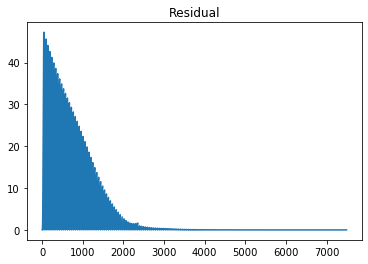

In [64]:
#Plot residual error
plt.plot(res_list)
plt.title("Residual")
plt.show()

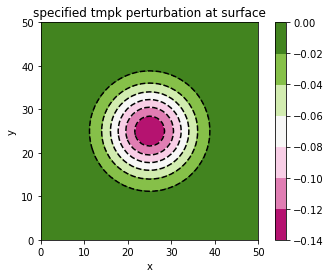

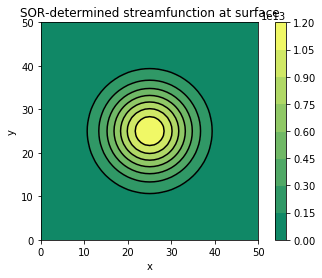

In [69]:
#Horizontal plot
lev = 0
# plot junk
fig,ax = plt.subplots()
cs1 = ax.contourf(x[:,:,lev],y[:,:,lev],tmpk_prime[:,:,lev],cmap='PiYG') 
cs = ax.contour(x[:,:,lev],y[:,:,lev],tmpk_prime[:,:,lev],colors='black')
fig.colorbar(cs1, orientation='vertical')
ax.set_title('specified tmpk perturbation at surface')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax=plt.gca()
ax.set_aspect('equal')
plt.show()       

fig,ax = plt.subplots()
cs1 = ax.contourf(x[:,:,lev],y[:,:,lev],psi[:,:,lev],cmap='summer')
cs = ax.contour(x[:,:,lev],y[:,:,lev],psi[:,:,lev],colors='black')
fig.colorbar(cs1)
ax.set_title('SOR-determined streamfunction at surface')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax=plt.gca()
ax.set_aspect('equal')
plt.show()

In [75]:
#Calculate mean psi at specified vertical level
lev = 19
psimean = np.mean(np.squeeze(psi[:,lev,:]))

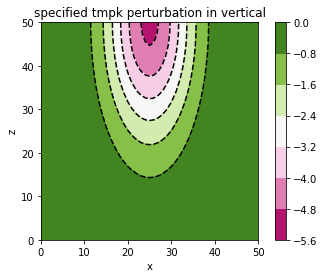

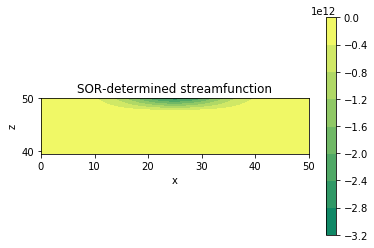

In [76]:
#Vertical cross section
lev = 25
# plot junk
fig = plt.figure()
cs1 = plt.contourf(x[:,lev,:],z[:,lev,:],tmpk_prime[:,lev,:],cmap='PiYG') 
cs = plt.contour(x[:,lev,:],z[:,lev,:],tmpk_prime[:,lev,:],colors='black')
fig.colorbar(cs1)
plt.title('specified tmpk perturbation in vertical')
plt.xlabel('x')
plt.ylabel('z')
ax=plt.gca()
ax.set_aspect('equal')
plt.show()       

lev = 19
fig = plt.figure()
cs1 = plt.contourf(x[:,lev,-5:],z[:,lev,-5:],psi[:,lev,-5:]-psimean,cmap='summer')
#cs = plt.contour(x[:,lev,:5],z[:,lev,:5],psi[:,lev,:5]-psimean,colors='black')
fig.colorbar(cs1)
plt.title('SOR-determined streamfunction')
plt.xlabel('x')
plt.ylabel('z')
ax=plt.gca()
ax.set_aspect('equal')
plt.show()